In [1]:
import tensorflow as tf
import keras
import logging
# === CONFIG ===
# Set random seeds and GPU memory growth
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

2026-02-06 14:44:44.066839: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 14:44:44.117312: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-06 14:44:44.117347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-06 14:44:44.118485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-06 14:44:44.126580: I tensorflow/core/platform/cpu_feature_guar

In [8]:
doc = db.collection("study_areas").document("Atlanta_Prediction").get()
print(doc.exists)


True


In [2]:
# Prediction mode
from usl_models.flood_ml import dataset
import pathlib

# Parameters
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
# prediction
sim_name = ["Atlanta_Prediction"]
rainfall_sim = "Atlanta-Atlanta_config/Rainfall_Data_22.txt"

batch_size = 2
dataset_split="train"
# Download (prediction mode)
# dataset.download_dataset(
#     sim_names=sim_name,          # study area
#     output_path=filecache_dir,
#     include_labels=False,                      # no labels
#     rainfall_sim_name=rainfall_sim,  # simulation for temporal vector
#     allow_missing_sim=True                     # skip temporal if missing
# )
# prediction mode
# # # Load dataset
# full_dataset = dataset.load_dataset_cached(
#     filecache_dir=filecache_dir,
#     sim_names=sim_name,            # study area
#     dataset_split=None,                          # no split for prediction
#     batch_size=batch_size,
#     include_labels=False,
#     shuffle=False,
#     rainfall_sim_name=rainfall_sim  # actual rainfall sim
# )


# Download (training mode)
# dataset_splits = ["test", "train", "val"]
# dataset.download_dataset(
#     sim_names=["Atlanta-Atlanta_config/Rainfall_Data_22.txt"],  # normal simulations
#     output_path=filecache_dir,
#     dataset_splits=dataset_splits,               # train/val/test splits
#     include_labels=True                        # get labels too
# )

full_dataset = dataset.load_dataset_cached(
    filecache_dir=filecache_dir,
    sim_names=["Manhattan-Manhattan_config/Rainfall_Data_25.txt"],
    dataset_split=dataset_split,
    batch_size=batch_size,
    include_labels=True
)


2026-02-06 14:44:47.122621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38364 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [ ]:
from usl_models.flood_ml.model import SpatialAttention
# Path to your saved model
model_path = "/home/se2890/climateiq-cnn-9/logs/htune_project_20251008-204114/model"
N_STEPS = 4  # Number of time steps the model wants to predict ahead
loaded_model = tf.keras.models.load_model(model_path)
loaded_model.summary()
# Load the model
model = tf.keras.models.load_model(model_path)
# model = FloodModel.from_checkpoint(model_path)
custom_objects = {'SpatialAttention': SpatialAttention}
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects=custom_objects,
    compile=False
)
model.set_weights(loaded_model.get_weights())

# Test calling the model for n predictions
# full_dataset = load_dataset(sim_names=sim_names, batch_size=4, dataset_split= "train")
inputs, labels,  name = next(iter(full_dataset))
predictions = model.call_n(inputs, n=N_STEPS)
predictions.shape

In [ ]:
import tensorflow as tf
import numpy as np

all_max_preds_np = []    # list of [B, H, W] NumPy arrays
all_max_labels_np = []   # only filled if true labels exist
all_chunk_names = []

for i, (inputs, labels, metadata) in enumerate(full_dataset):
    current_bs = inputs["spatiotemporal"].shape[0]
    chunk_names = metadata["feature_chunk"].numpy().astype(str).tolist()
    all_chunk_names.extend(chunk_names)

    print(f"\n[Batch {i}] Chunk names: {chunk_names}")

    # --- Handle incomplete batches ---
    if current_bs < batch_size:
        repeats = batch_size - current_bs

        def pad_tensor(t):
            return tf.concat([t, tf.repeat(t[-1:], repeats=repeats, axis=0)], axis=0)

        padded_inputs = {k: pad_tensor(v) for k, v in inputs.items()}
        preds = model.call_n(padded_inputs, n=N_STEPS)[:current_bs]
    else:
        preds = model.call_n(inputs, n=N_STEPS)

    print(f"[Batch {i}] Prediction shape: {preds.shape}")

    # --- Convert predictions immediately to NumPy (CPU-safe) ---
    preds_np = preds.numpy()
    max_pred_np = np.max(preds_np, axis=1)   # [B, H, W]
    all_max_preds_np.append(max_pred_np)

    # --- Only store real labels (skip dummy zeros in prediction mode) ---
    if tf.reduce_sum(tf.cast(labels != 0.0, tf.int32)) > 0:
        labels_np = labels.numpy()
        max_label_np = np.max(labels_np, axis=1)
        all_max_labels_np.append(max_label_np)

# --- Final NumPy arrays on CPU ---
max_preds_all_np = np.concatenate(all_max_preds_np, axis=0)            # [N, H, W]
max_labels_all_np = (
    np.concatenate(all_max_labels_np, axis=0) if all_max_labels_np else None
)

print("\n✅ Aggregation complete:")
print(f"  - Chunks: {len(all_chunk_names)}")
print(f"  - max_preds_all_np: {max_preds_all_np.shape}")
print(f"  - max_labels_all_np: {'None' if max_labels_all_np is None else max_labels_all_np.shape}")


In [ ]:
import matplotlib.pyplot as plt

i = min(10, len(all_chunk_names) - 1)  # safe index

plt.figure(figsize=(10, 4))

# --- Prediction map ---
plt.subplot(1, 2, 1)
plt.imshow(max_preds_all_np[i], cmap="Blues")
plt.title(f"Predicted Max Flood ({all_chunk_names[i]})")
plt.colorbar()

# --- Ground truth or “no labels” notice ---
plt.subplot(1, 2, 2)
if max_labels_all_np is not None:
    plt.imshow(max_labels_all_np[i], cmap="Blues")
    plt.title("Ground Truth Max Flood")
    plt.colorbar()
else:
    plt.axis("off")
    plt.text(
        0.5, 0.5,
        "No Ground Truth Available\n(Prediction Mode)",
        ha="center", va="center",
        fontsize=12,
        color="gray",
    )

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_to_plot = min(5, len(max_preds_all_np))  # limit to available samples
has_labels = max_labels_all_np is not None   # prediction vs training mode

# --- Layout ---
ncols = 2 if has_labels else 1
fig, axes = plt.subplots(
    num_to_plot,
    ncols,
    figsize=(8 if has_labels else 4, num_to_plot * 4),
    squeeze=False,  # always 2D array of axes
)

fig.subplots_adjust(wspace=0.05, hspace=0.25)

for i in range(num_to_plot):
    pred = max_preds_all_np[i]

    # Dynamic color scaling (robust to outliers)
    if has_labels:
        truth = max_labels_all_np[i]
        combined = np.concatenate([pred.flatten(), truth.flatten()])
        vmin = np.percentile(combined, 2)
        vmax = np.percentile(combined, 98)
    else:
        vmin = np.percentile(pred, 2)
        vmax = np.percentile(pred, 98)

    # --- Prediction map ---
    ax_pred = axes[i, 0]
    im_pred = ax_pred.imshow(pred, cmap="cubehelix", vmin=vmin, vmax=vmax)
    ax_pred.set_title(f"ML Prediction {i}", fontsize=11)
    ax_pred.axis("off")

    # --- Ground truth / placeholder ---
    if has_labels:
        ax_truth = axes[i, 1]
        ax_truth.imshow(truth, cmap="cubehelix", vmin=vmin, vmax=vmax)
        ax_truth.set_title(f"Ground Truth {i}", fontsize=11)
        ax_truth.axis("off")
    else:
        # Add placeholder notice next to the prediction
        ax_note = ax_pred.twinx()  # overlay note to the right of the image
        ax_note.axis("off")
        ax_note.text(
            1.05, 0.5,
            "No Ground Truth\nAvailable",
            transform=ax_pred.transAxes,
            ha="left",
            va="center",
            fontsize=11,
            color="gray",
        )

# --- Shared colorbar ---
cbar_ax = fig.add_axes([0.93, 0.3, 0.015, 0.4])
fig.colorbar(im_pred, cax=cbar_ax, label="Maximum Water Depth (m)")

plt.suptitle(
    "Rainfall Scenario 1 (1-hour storm) – Location: Atlanta",
    fontsize=14,
    y=0.98,
)
plt.tight_layout(rect=[0, 0, 0.91, 0.97])
plt.show()


In [ ]:
# pip install rasterio

In [ ]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
from google.cloud import storage
import tempfile
import os
# === Notebook inputs ===
sim_name = ["MNHT_test_Prediction"]
rainfall_sim = "MNHT_test_Prediction/Rainfall_Data_22.txt"
# === Geo metadata ===
pixel_size = 1
top_left_x = 0
top_left_y = 0
transform = from_origin(top_left_x, top_left_y, pixel_size, pixel_size)
crs = "EPSG:4326"

# === GCS setup ===
client = storage.Client()
bucket_name = "mloutputstest"
bucket = client.bucket(bucket_name)



rainfall_scenario = rainfall_sim.split("/")[-1]  # e.g. "Rainfall_Data_22.txt"
study_area = sim_name[0]                         # e.g. "Manhattan-Manhattan_config_Prediction"

# === Define GCS folder structure ===
base_folder = f"{study_area}/scenario_{rainfall_scenario}"
tif_folder = f"{base_folder}/tif"
png_folder = f"{base_folder}/png"

# === Final arrays on CPU ===
N = max_preds_all_np.shape[0]
has_labels = max_labels_all_np is not None

print(f"\nSaving {N} predicted chunks to gs://{bucket_name}/{base_folder}")
print(f"Ground-truth labels detected: {has_labels} (will NOT be uploaded)")

for idx in range(N):
    chunk_name = all_chunk_names[idx] if idx < len(all_chunk_names) else f"chunk_{idx}"
    sample = max_preds_all_np[idx]  # Already NumPy on CPU

    # --- Save GeoTIFF (prediction only) ---
    with tempfile.NamedTemporaryFile(suffix=".tif") as tmp_tif:
        with rasterio.open(
            tmp_tif.name,
            "w",
            driver="GTiff",
            height=sample.shape[0],
            width=sample.shape[1],
            count=1,
            dtype=sample.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(sample, 1)

        tif_blob_path = f"{tif_folder}/{chunk_name}.tif"
        bucket.blob(tif_blob_path).upload_from_filename(tmp_tif.name)
        print(f"✅ Uploaded GeoTIFF: gs://{bucket_name}/{tif_blob_path}")

    # --- Save PNG (prediction only) ---
    with tempfile.NamedTemporaryFile(suffix=".png") as tmp_png:
        plt.imsave(tmp_png.name, sample, cmap="Blues")
        png_blob_path = f"{png_folder}/{chunk_name}.png"
        bucket.blob(png_blob_path).upload_from_filename(tmp_png.name)
        print(f"✅ Uploaded PNG: gs://{bucket_name}/{png_blob_path}")

print("\n✅ All prediction files uploaded successfully.")


In [ ]:
# Different model comparisons

In [3]:
from usl_models.flood_ml.model import SpatialAttention

# Put all 5 model paths here
model_paths = [
    "/home/se2890/climateiq-cnn-main/logs/training_20260202-215118--k-2-50-epochs-tnuer64/model",
    "/home/se2890/climateiq-cnn-main/logs/training_20260202-k-1-50-epochs-tnuer64/model",
    "/home/se2890/climateiq-cnn-main/logs/training_20260202-k-5-50-epochs-tuner64-auto/model",
    "/home/se2890/climateiq-cnn-main/logs/training_20260203--k-5-50-epochs-tuner64-GT/model",
    "/home/se2890/climateiq-cnn-main/logs/training_20260203-k-2-50-pochs-tuner64-GT/model",
]

N_STEPS = 4  # predict ahead

# Load one batch (same input for all models)
inputs, labels, name = next(iter(full_dataset))

# Store predictions for each model
all_predictions = {}

custom_objects = {"SpatialAttention": SpatialAttention}

for path in model_paths:

    print("\nLoading model:", path)

    loaded_model = tf.keras.models.load_model(
        path,
        custom_objects=custom_objects,
        compile=False
    )

    # Predict
    preds = loaded_model.call_n(inputs, n=N_STEPS)

    print("Prediction shape:", preds.shape)

    # Save
    all_predictions[path] = preds.numpy()



Loading model: /home/se2890/climateiq-cnn-main/logs/training_20260202-215118--k-2-50-epochs-tnuer64/model


2026-02-06 14:45:01.497846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900


Prediction shape: (2, 4, 1000, 1000)

Loading model: /home/se2890/climateiq-cnn-main/logs/training_20260202-k-1-50-epochs-tnuer64/model
Prediction shape: (2, 4, 1000, 1000)

Loading model: /home/se2890/climateiq-cnn-main/logs/training_20260202-k-5-50-epochs-tuner64-auto/model
Prediction shape: (2, 4, 1000, 1000)

Loading model: /home/se2890/climateiq-cnn-main/logs/training_20260203--k-5-50-epochs-tuner64-GT/model
Prediction shape: (2, 4, 1000, 1000)

Loading model: /home/se2890/climateiq-cnn-main/logs/training_20260203-k-2-50-pochs-tuner64-GT/model
Prediction shape: (2, 4, 1000, 1000)


In [4]:
from usl_models.flood_ml.model import SpatialAttention

custom_objects = {"SpatialAttention": SpatialAttention}

# ✅ Load all 5 models once
models = {}

for path in model_paths:
    print("Loading:", path)
    models[path] = tf.keras.models.load_model(
        path,
        custom_objects=custom_objects,
        compile=False
    )

print("✅ All models loaded:", len(models))


Loading: /home/se2890/climateiq-cnn-main/logs/training_20260202-215118--k-2-50-epochs-tnuer64/model
Loading: /home/se2890/climateiq-cnn-main/logs/training_20260202-k-1-50-epochs-tnuer64/model
Loading: /home/se2890/climateiq-cnn-main/logs/training_20260202-k-5-50-epochs-tuner64-auto/model
Loading: /home/se2890/climateiq-cnn-main/logs/training_20260203--k-5-50-epochs-tuner64-GT/model
Loading: /home/se2890/climateiq-cnn-main/logs/training_20260203-k-2-50-pochs-tuner64-GT/model
✅ All models loaded: 5


In [5]:
import tensorflow as tf
import numpy as np

# ✅ store predictions separately per model
all_max_preds_np = {path: [] for path in model_paths}

all_max_labels_np = []
all_chunk_names = []

for i, (inputs, labels, metadata) in enumerate(full_dataset):
    current_bs = inputs["spatiotemporal"].shape[0]
    chunk_names = metadata["feature_chunk"].numpy().astype(str).tolist()
    all_chunk_names.extend(chunk_names)

    print(f"\n[Batch {i}] Chunk names: {chunk_names}")

    # --- Handle incomplete batches ---
    if current_bs < batch_size:
        repeats = batch_size - current_bs

        def pad_tensor(t):
            return tf.concat([t, tf.repeat(t[-1:], repeats=repeats, axis=0)], axis=0)

        padded_inputs = {k: pad_tensor(v) for k, v in inputs.items()}
    else:
        padded_inputs = inputs

    # ✅ Run all models on the SAME batch
    for path, model in models.items():

        preds = model.call_n(padded_inputs, n=N_STEPS)[:current_bs]

        print(f"[Batch {i}] Model {path.split('/')[-2]} pred shape: {preds.shape}")

        preds_np = preds.numpy()
        max_pred_np = np.max(preds_np, axis=1)   # [B, H, W]

        all_max_preds_np[path].append(max_pred_np)

    # --- Only store real labels (skip dummy zeros in prediction mode) ---
    if tf.reduce_sum(tf.cast(labels != 0.0, tf.int32)) > 0:
        labels_np = labels.numpy()
        max_label_np = np.max(labels_np, axis=1)
        all_max_labels_np.append(max_label_np)


# ✅ Final NumPy arrays per model
max_preds_all_np = {
    path: np.concatenate(all_max_preds_np[path], axis=0)
    for path in model_paths
}

max_labels_all_np = (
    np.concatenate(all_max_labels_np, axis=0) if all_max_labels_np else None
)

print("\n✅ Aggregation complete:")
print(f"  - Chunks: {len(all_chunk_names)}")

for path in model_paths:
    print(f"  - Model {path.split('/')[-2]} max_preds: {max_preds_all_np[path].shape}")

print(f"  - max_labels_all_np: {'None' if max_labels_all_np is None else max_labels_all_np.shape}")



[Batch 0] Chunk names: ['3_7', '4_5']
[Batch 0] Model training_20260202-215118--k-2-50-epochs-tnuer64 pred shape: (2, 4, 1000, 1000)
[Batch 0] Model training_20260202-k-1-50-epochs-tnuer64 pred shape: (2, 4, 1000, 1000)
[Batch 0] Model training_20260202-k-5-50-epochs-tuner64-auto pred shape: (2, 4, 1000, 1000)
[Batch 0] Model training_20260203--k-5-50-epochs-tuner64-GT pred shape: (2, 4, 1000, 1000)
[Batch 0] Model training_20260203-k-2-50-pochs-tuner64-GT pred shape: (2, 4, 1000, 1000)

[Batch 1] Chunk names: ['2_9', '1_7']
[Batch 1] Model training_20260202-215118--k-2-50-epochs-tnuer64 pred shape: (2, 4, 1000, 1000)
[Batch 1] Model training_20260202-k-1-50-epochs-tnuer64 pred shape: (2, 4, 1000, 1000)
[Batch 1] Model training_20260202-k-5-50-epochs-tuner64-auto pred shape: (2, 4, 1000, 1000)
[Batch 1] Model training_20260203--k-5-50-epochs-tuner64-GT pred shape: (2, 4, 1000, 1000)
[Batch 1] Model training_20260203-k-2-50-pochs-tuner64-GT pred shape: (2, 4, 1000, 1000)

[Batch 2] Chu

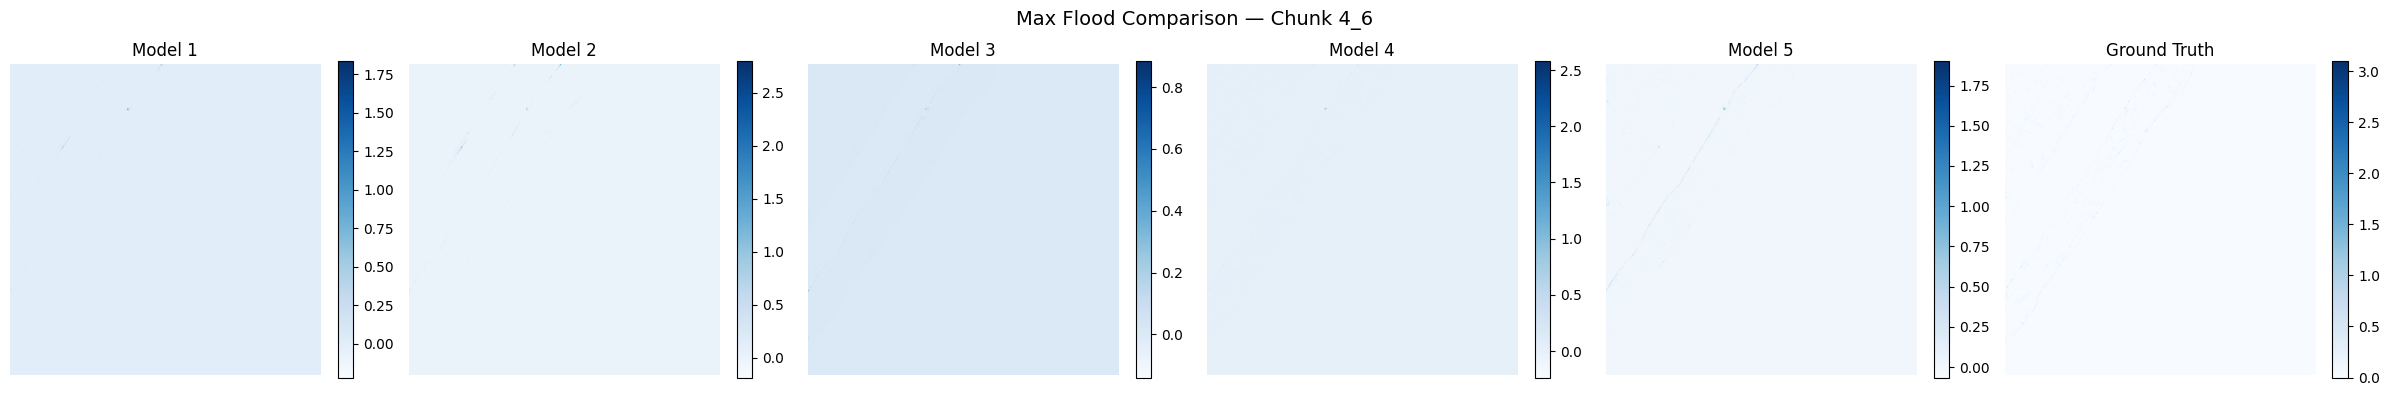

In [6]:
import matplotlib.pyplot as plt

i = min(10, len(all_chunk_names) - 1)  # safe index

num_models = len(model_paths)

plt.figure(figsize=(4 * (num_models + 1), 4))

# --- Plot each model prediction ---
for j, path in enumerate(model_paths):

    plt.subplot(1, num_models + 1, j + 1)

    pred_map = max_preds_all_np[path][i]

    plt.imshow(pred_map, cmap="Blues")
    plt.title(f"Model {j+1}")
    plt.axis("off")
    plt.colorbar(fraction=0.046)

# --- Plot Ground Truth once at the end ---
plt.subplot(1, num_models + 1, num_models + 1)

if max_labels_all_np is not None:
    plt.imshow(max_labels_all_np[i], cmap="Blues")
    plt.title("Ground Truth")
    plt.axis("off")
    plt.colorbar(fraction=0.046)
else:
    plt.axis("off")
    plt.text(
        0.5, 0.5,
        "No Ground Truth Available\n(Prediction Mode)",
        ha="center", va="center",
        fontsize=12,
        color="gray",
    )

plt.suptitle(f"Max Flood Comparison — Chunk {all_chunk_names[i]}", fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
inputs, labels, metadata = next(iter(full_dataset))

chunk_name = metadata["feature_chunk"].numpy()[0].decode()
print("Using chunk:", chunk_name)


Using chunk: 3_4


In [8]:
all_preds = {}

for j, path in enumerate(model_paths):

    model = models[path]

    preds = model.call_n(inputs, n=N_STEPS)  # (B, T, H, W)

    all_preds[path] = preds.numpy()[0]       # (T, H, W)

print("✅ Predictions collected for all models.")


✅ Predictions collected for all models.


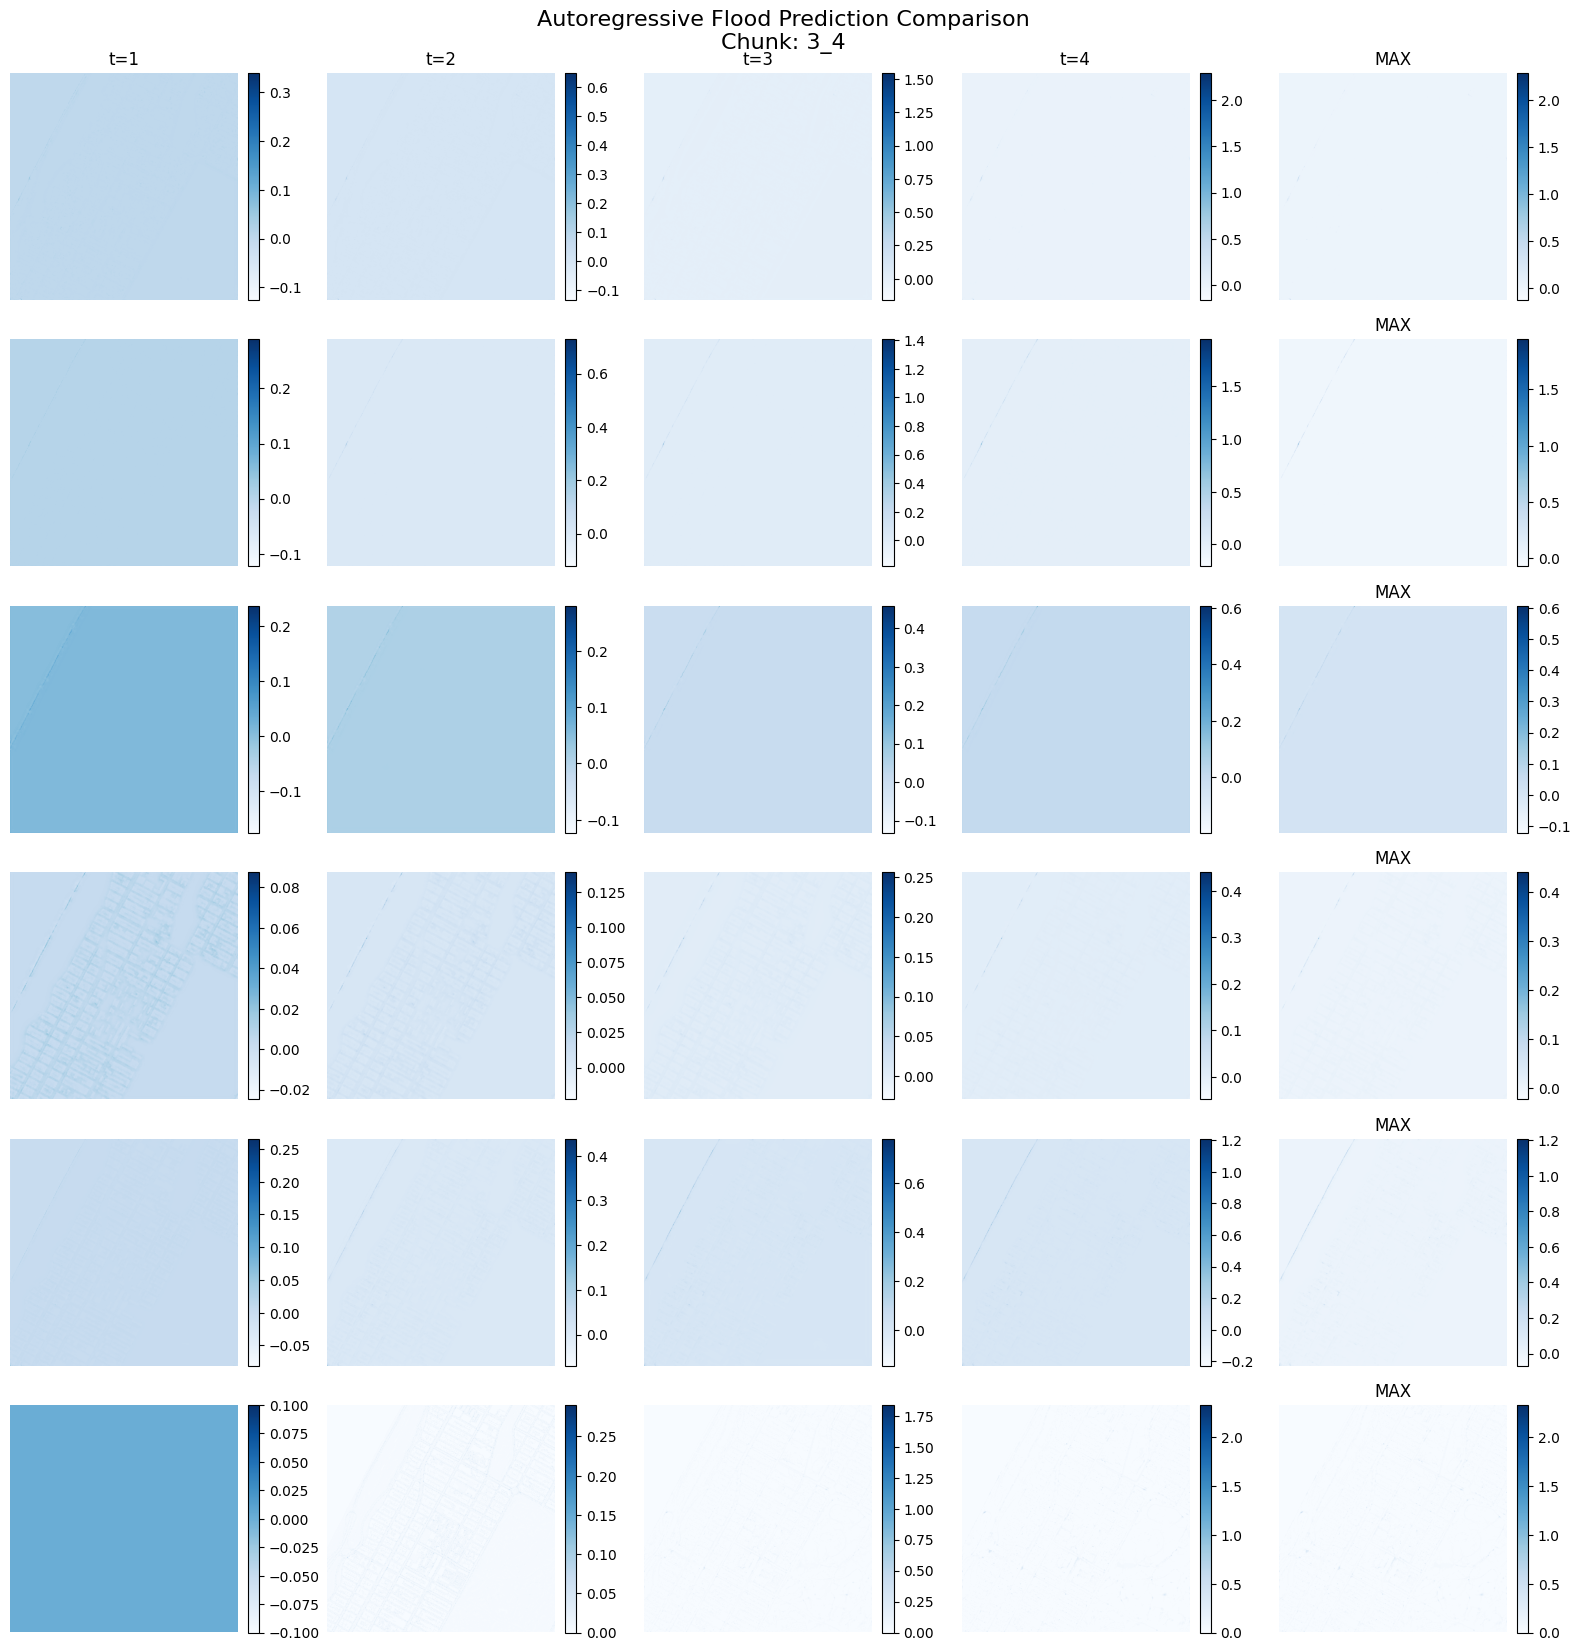

In [15]:
import matplotlib.pyplot as plt
import numpy as np

steps = N_STEPS
num_models = len(model_paths)

# Ground truth sequence
gt_seq = labels.numpy()[0][:steps]        # (T, H, W)
gt_max = np.max(gt_seq, axis=0)

rows = num_models + 1
cols = steps + 1

fig, axes = plt.subplots(
    rows, cols,
    figsize=(3.2 * cols, 2.8 * rows),
    squeeze=False
)

# -----------------------------
# Plot model predictions
# -----------------------------
for r, path in enumerate(model_paths):
    short_name = f"Model {r+1}"

    for t in range(steps):
        ax = axes[r, t]

        im = ax.imshow(all_preds[path][t], cmap="Blues")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax.axis("off")
        if r == 0:
            ax.set_title(f"t={t+1}")

    # MAX over rollout
    ax = axes[r, steps]
    im = ax.imshow(np.max(all_preds[path], axis=0), cmap="Blues")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.axis("off")
    ax.set_title("MAX")

    # Row label
    axes[r, 0].set_ylabel(short_name, fontsize=12)


# -----------------------------
# Plot Ground Truth row
# -----------------------------
gt_row = num_models

for t in range(steps):
    ax = axes[gt_row, t]

    im = ax.imshow(gt_seq[t], cmap="Blues")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.axis("off")

ax = axes[gt_row, steps]
im = ax.imshow(gt_max, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.axis("off")
ax.set_title("MAX")

axes[gt_row, 0].set_ylabel("Ground Truth", fontsize=12)


# -----------------------------
# Figure title
# -----------------------------
plt.suptitle(
    f"Autoregressive Flood Prediction Comparison\nChunk: {chunk_name}",
    fontsize=16
)

plt.tight_layout()
plt.show()


In [16]:
print("GT min:", gt_seq.min())
print("GT max:", gt_seq.max())


GT min: 0.0
GT max: 2.329
